In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u

import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
import mplcyberpunk

plt.style.use("cyberpunk")

In [4]:
#  mplcyberpunk.add_glow_effects()

In [5]:
path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

['/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehub3010_x1d.fits']

In [6]:
cpath = '/media/david/5tb_storage1/pceb_data/eg_uma/'
x = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(x, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

mask = (wc < 1210) | (wc > 1220)
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]
#plt.plot(wc1, fc1)

In [7]:
data = fits.getdata(x1ds[0])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

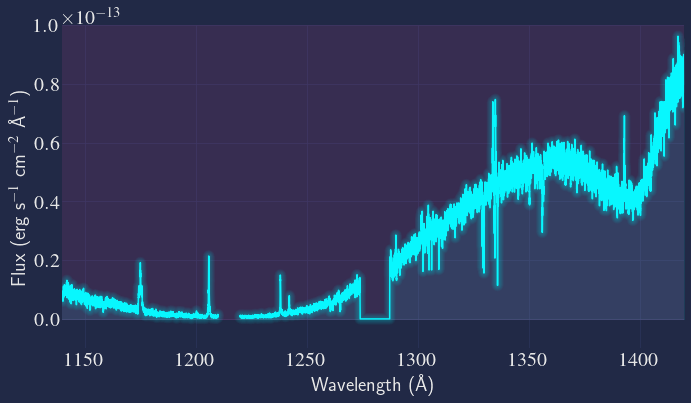

In [27]:
plt.figure(figsize=(10, 6))
mask = (wc < 1210)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) #& (wc < 1270)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220)
# plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.legend(frameon=True)
plt.xlim(1140, 1420)
plt.ylim(-0.1e-13, 1e-13)

plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')

mplcyberpunk.add_glow_effects()

plt.tight_layout()
plt.savefig('plots/eg_uma_cos_cp.png', dpi=150)

Can I make a 3d plot of a flt file?

In [8]:
flts = glob.glob('{}*flt.fits'.format(path))
flts

['/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_flt.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_flt.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_flt.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehub3010_flt.fits']

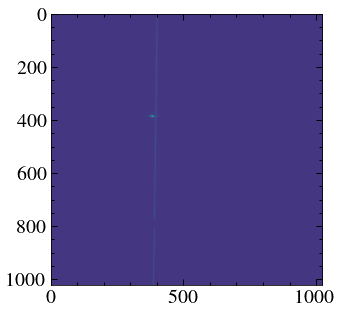

In [9]:
fdat = fits.getdata(flts[0],1)
plt.imshow(fdat)

In [10]:
fits.getheader(flts[0],1)

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2021-04-02' / date this file was written (yyyy-mm-dd)                
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'oehua1010        

here


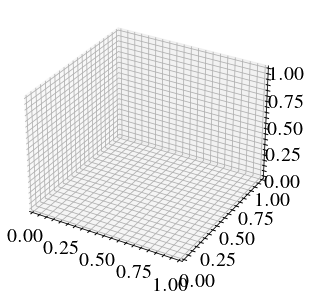

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(projection='3d')
# ax1.plot(fdat)

fdat = np.array(fdat)

x_data, y_data = np.meshgrid( np.arange(fdat.shape[1]),
                              np.arange(fdat.shape[0]) )
#
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()



#print('here')
#z_data = fdat.flatten()
print('here')
#ax1.bar3d( x_data,
#          y_data,
 #         np.zeros(len(z_data)),
  #        1, 1, z_data )
plt.show()

In [12]:
np.histogram

<function numpy.histogram(a, bins=10, range=None, normed=None, weights=None, density=None)>

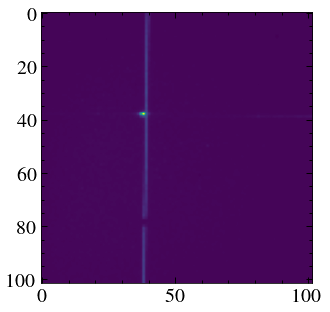

In [13]:
def binArray(data, axis, binstep, binsize, func=np.nanmean):
    data = np.array(data)
    dims = np.array(data.shape)
    argdims = np.arange(data.ndim)
    argdims[0], argdims[axis]= argdims[axis], argdims[0]
    data = data.transpose(argdims)
    data = [func(np.take(data,np.arange(int(i*binstep),int(i*binstep+binsize)),0),0) for i in np.arange(dims[axis]//binstep)]
    data = np.array(data).transpose(argdims)
    return data


data_matrix = fdat
binned_data = binArray(data_matrix, 0, 10, 10, np.sum)
binned_data = binArray(binned_data, 1, 10, 10, np.sum)

plt.imshow(binned_data)

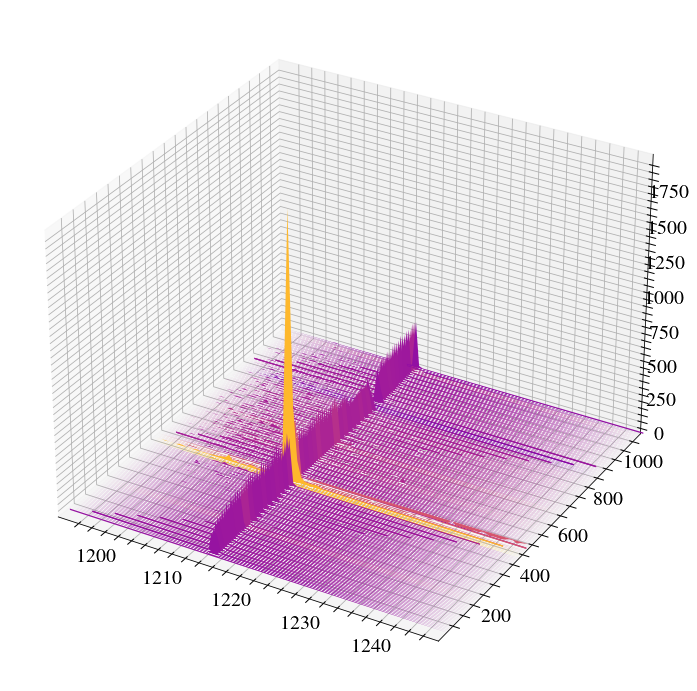

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(projection='3d')
# ax1.plot(fdat)

fdat = np.array(fdat)

x_data, y_data = np.meshgrid( np.linspace(1194, 1249, binned_data.shape[1]),
                              np.linspace(0, 1024, binned_data.shape[0]) )


#
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()



# #print('here')
# zeroed_data = binned_data.flatten()
# for i in range(len(zeroed_data)):
#     if zeroed_data[i] < 0:
#         zeroed_data[i] = 0
        

# z_data = np.log10(zeroed_data)
#print('here')
z_data = binned_data.flatten()
for i in range(len(z_data)):
     if z_data[i] < 10:
        z_data[i] = 10

z = np.array([np.zeros(len(z_data)), z_data])

surf = ax1.plot_surface(x_data, y_data, z, cmap=cm.plasma,
                       vmin=0, vmax=20,linewidth=0, antialiased=True)

ax1.set_ylim(1, 1023)
ax1.set_xlim(1194, 1247)



plt.tight_layout()

# plt.show()

In [16]:
phase = np.array([0.75, 0.5, 0.0, 0.25])

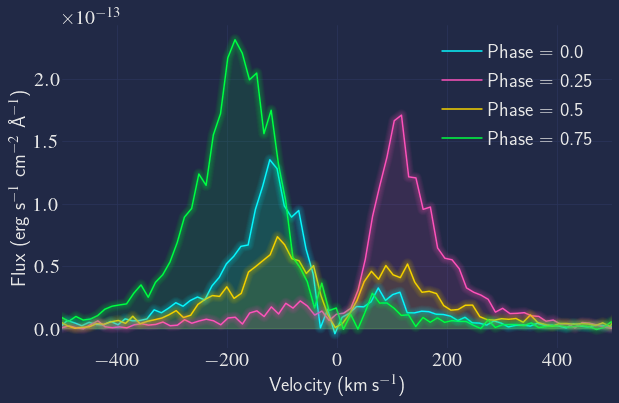

In [28]:
lya = 1215.67

args = np.argsort(phase)
phaseord = phase[args]
plt.figure(figsize=(9, 6))
x1ds_phase = np.array(x1ds)[args] 
for i, x in enumerate(x1ds_phase):    
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
#     plt.step(v, f, where='mid', label='Phase = {}'.format(phaseord[i]))
    plt.plot(v, f, label='Phase = {}'.format(phaseord[i]))
plt.xlim(-500, 500)
plt.legend()
plt.xlabel('Velocity (km\,s$^{-1}$)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
mplcyberpunk.add_glow_effects()
plt.tight_layout()
# plt.savefig('plots/eg_uma_all_lya.pdf', dpi=150)

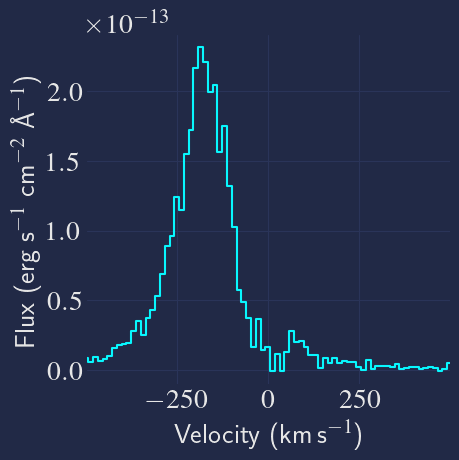

In [30]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(5, 5))
fig.set_dpi(100)

ax = plt.axes(xlim=(-499, 499), ylim=(-0.1e-13, 2.4e-13))

# ax.set_ylim(-0.1e-13, 2.4e-13)
# ax.set_xlim(-500, 500)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Velocity (km\,s$^{-1}$)')

line1, = ax.step([0,0],[0,0], where='mid')

def update(i):
    data = fits.getdata(x1ds_phase[i], 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    v = (w*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
    line1.set_xdata(v)
    line1.set_ydata(f)
    
    return ax, line1
fig.set_tight_layout(True)
# fig.patch.set_facecolor('w')
mplcyberpunk.add_glow_effects()

anim = FuncAnimation(fig, update, frames=np.arange(len(x1ds_phase)), interval=300)
anim.save('plots/eguma_lya_cp.gif', dpi=100, writer='imagemagick')
plt.show()